In [ ]:
import numpy as np
import scipy.io as sio
from ADLCC import ADLCC_wrapper, print_performance_summary
import matplotlib.pyplot as plt
from auto_dlcc_functions import cluster2cv
import pandas as pd
from sklearn.preprocessing import StandardScaler
# Set random seed
default_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#393b79", "#8c6d31", "#e7ba52", "#637939", "#843c39",
    "#7b4173", "#a55194", "#6b6ecf", "#bd9e39", "#ce6dbd", "#5254a3"
]
def get_colors(n):
    
    if n <= len(default_colors):
        return default_colors[:n]
    else:
      
        return (default_colors * ((n // len(default_colors)) + 1))[:n]

def plot_clustering_results(current_data, current_labels, current_dataset_name, result_info):
    
    """Visualize clustering results: temporary clusters and final results
    
    Args:
        result_info: Complete ADLCC result dictionary
    """
    
    # Get strategy and clustering results
    strategy = result_info['AUTO_DLCC_output']['strategy']
    print(f"Strategy used: {strategy}")
    print(f"Data shape: {current_data.shape}")
    
    # Extract temp_clus and final results
    temp_clus = result_info['AUTO_DLCC_output']['temp_clus']
    final_cluster_vector = result_info['AUTO_DLCC_output']['cluster_result']['cluster_vector']
    
    # Convert temp_clus to cluster vector for visualization
    temp_cluster_vector = cluster2cv(current_data, temp_clus)
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    # Plot 1: Ground truth
    unique_true_labels = np.unique(current_labels)
    true_colors = get_colors(len(unique_true_labels))
    axes[0].set_title(f'{current_dataset_name} - Ground Truth')
    for i, label in enumerate(unique_true_labels):
        mask = current_labels == label
        axes[0].scatter(current_data[mask, 0], current_data[mask, 1], 
                        color=true_colors[i], alpha=0.7, s=50)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc="best", fontsize=8, frameon=False)

    # Plot 2: Temporary clusters
    unique_temp_clusters = np.unique(temp_cluster_vector)
    temp_colors = get_colors(len(unique_temp_clusters))
    axes[1].set_title(f'{current_dataset_name} - Temporary Clusters')
    noise_mask = temp_cluster_vector == 0
    if np.any(noise_mask):
        axes[1].scatter(current_data[noise_mask, 0], current_data[noise_mask, 1], 
                        color='lightgray', alpha=0.5, s=30, marker='x')
    for i, cluster_id in enumerate(unique_temp_clusters):
        if cluster_id != 0:
            mask = temp_cluster_vector == cluster_id
            axes[1].scatter(current_data[mask, 0], current_data[mask, 1], 
                            color=temp_colors[i], alpha=0.7, s=50, label=f"C{cluster_id}")
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Final clusters
    unique_final_clusters = np.unique(final_cluster_vector)
    final_colors = get_colors(len(unique_final_clusters))
    axes[2].set_title(f'{current_dataset_name} - Final Clusters ({strategy})')
    for i, cluster_id in enumerate(unique_final_clusters):
        if cluster_id != 0:
            mask = final_cluster_vector == cluster_id
            axes[2].scatter(current_data[mask, 0], current_data[mask, 1], 
                            color=final_colors[i], alpha=0.7, s=50, label=f"C{cluster_id}")
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def load_mat_dataset(file_path, dataset_name):
    """Load .mat dataset"""
    global current_data, current_labels, current_dataset_name

    try:
        print(f"\n=== Loading {dataset_name} Dataset ===")
        mat_data = sio.loadmat(file_path)
        print(f"File contents: {list(mat_data.keys())}")

        # Usually data is in 'X' or 'data' key, labels in 'Y' or 'labels' key
        if 'X' in mat_data and 'Y' in mat_data:
            data = mat_data['X']
            labels = mat_data['Y'].ravel()
        elif 'data' in mat_data and 'labels' in mat_data:
            data = mat_data['data']
            labels = mat_data['labels'].ravel()
        else:
            # Try to find suitable keys
            possible_data_keys = [k for k in mat_data.keys() if not k.startswith('__')]
            print(f"Possible data keys: {possible_data_keys}")

            if len(possible_data_keys) >= 2:
                data_key = possible_data_keys[0]
                label_key = possible_data_keys[1]
                data = mat_data[data_key]
                labels = mat_data[label_key].ravel()
                print(f"Using {data_key} as data, {label_key} as labels")
            elif len(possible_data_keys) == 1:
                # Only one key, need to check if first or last column is label
                arr = mat_data[possible_data_keys[0]]
                print(f"Single key '{possible_data_keys[0]}' with shape {arr.shape}")
                if arr.ndim == 2 and arr.shape[1] > 1:
                    first_col = arr[:, 0]
                    last_col = arr[:, -1]
                    def is_label(col):
                        return (
                            np.issubdtype(col.dtype, np.integer) or
                            np.all(np.mod(col, 1) == 0)
                        ) and len(np.unique(col)) <= 20
                    if is_label(first_col):
                        labels = first_col.ravel()
                        data = arr[:, 1:]
                        print("Detected first column as label.")
                    elif is_label(last_col):
                        labels = last_col.ravel()
                        data = arr[:, :-1]
                        print("Detected last column as label.")
                    else:
                        raise ValueError("Cannot identify label column in single-key .mat file")
                else:
                    raise ValueError("Single-key .mat file does not have 2D array with >1 columns")
            else:
                raise ValueError("Cannot identify data and labels")

        print(f"Data shape: {data.shape}")
        print(f"Labels shape: {labels.shape}")
        print(f"Unique labels: {np.unique(labels)}")
        print(f"Number of classes: {len(np.unique(labels))}")

        # Store in global variables for plot_clustering_results to use
        current_data = data
        current_labels = labels
        current_dataset_name = dataset_name

        return data, labels

    except Exception as e:
        print(f"Error loading {dataset_name}: {e}")
        return None, None


In [2]:
# Load Seeds dataset from UCI repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
seeds_df = pd.read_csv(url, delim_whitespace=True, header=None)

# Features: first 7 columns, Labels: 8th column
seeds_data = seeds_df.iloc[:, :7].values
seeds_labels = seeds_df.iloc[:, 7].values

print(f'Data shape: {seeds_data.shape}')
print(f'Labels shape: {seeds_labels.shape}')
print(f'Number of classes: {len(np.unique(seeds_labels))}')


C:\Users\tgy23\AppData\Local\Temp\ipykernel_5664\3711110527.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  seeds_df = pd.read_csv(url, delim_whitespace=True, header=None)


Data shape: (210, 7)
Labels shape: (210,)
Number of classes: 3


In [3]:
#input labels only for evaluation
seed_result = ADLCC_wrapper(
    data=seeds_data, 
    labels=seeds_labels, 
)
print_performance_summary(seed_result)


Using CPU for spatial depth computation

=== ADLCC Performance Summary ===
Strategy: centroid

Temporary Clustering:
  Coverage: 77.14%
  ARI: 0.9478
  NMI: 0.9165
  Purity: 0.9815

Final Clustering:
  Coverage: 100.00%
  ARI: 0.7617
  NMI: 0.7142
  Purity: 0.9143


In [4]:
# Load Breast Cancer Wisconsin dataset
url_bc = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
data_bc = pd.read_csv(url_bc, header=None)

# Extract data and labels (V1 is ID, V2 is diagnosis)
bc_label = data_bc.iloc[:, 1].values  # Second column (V2)
bc_data = data_bc.drop([0, 1], axis=1)  # Drop first two columns (V1, V2)

# Convert labels to numeric (M=1, B=0)
bc_label_numeric = np.where(bc_label == 'M', 1, 0)
bc_label_numeric=bc_label_numeric+1
# Scale the data
scaler_bc = StandardScaler()
bc_data_scaled = scaler_bc.fit_transform(bc_data)



In [5]:
# Set random seed for reproducibility
np.random.seed(2025)

# Run ADLCC on Breast Cancer dataset with default KNN classification
result_bc = ADLCC_wrapper(
    data=bc_data_scaled, 
    labels=bc_label_numeric, 
)
print_performance_summary(result_bc)


Using CPU for spatial depth computation

=== ADLCC Performance Summary ===
Strategy: centroid

Temporary Clustering:
  Coverage: 78.73%
  ARI: 0.9641
  NMI: 0.9306
  Purity: 0.9911

Final Clustering:
  Coverage: 100.00%
  ARI: 0.7855
  NMI: 0.7256
  Purity: 0.9438


## Local data examples, run both strategies 

In [6]:

# Load segmentation dataset
segmentation = pd.read_csv('data/segmentation.test', skiprows=5, header=None)
segmentation = segmentation.drop_duplicates()

seg_label = segmentation.iloc[:, 0]
seg_data = segmentation.drop([0, 3], axis=1)  

# Convert seg_label from text to numeric cluster labels (1-based)
seg_label = pd.factorize(seg_label)[0] + 1
# Standardize the data
scaler = StandardScaler()
seg_data = scaler.fit_transform(seg_data)

print(f'Segmentation data shape: {seg_data.shape}')
print(f'Labels shape: {seg_label.shape}')


Segmentation data shape: (2086, 18)
Labels shape: (2086,)


In [7]:
# Set random seed for reproducibility
np.random.seed(2025)

# Run ADLCC with 'both' strategy
result_both = ADLCC_wrapper(
    data=seg_data,
    labels=seg_label, 
    class_method='rf',
    strategy='both',
    use_gpu=True
)
print_performance_summary(result_both)

Estimated memory: 166.6MB, GPU available: 12287.5MB - Using GPU

=== ADLCC Performance Summary ===
Strategy: both

Linkage Strategy:
  Temporary - Coverage: 95.25%, ARI: 0.2688, NMI: 0.5406, Purity: 0.5249
  Final - Coverage: 100.00%, ARI: 0.2589, NMI: 0.5300, Purity: 0.5125

Centroid Strategy:
  Temporary - Coverage: 79.96%, ARI: 0.5857, NMI: 0.6646, Purity: 0.7908
  Final - Coverage: 100.00%, ARI: 0.4763, NMI: 0.6134, Purity: 0.7474


# An example with visualizations.


=== Loading Ba Dataset ===
File contents: ['__header__', '__version__', '__globals__', 'ba', 'ba_label']
Possible data keys: ['ba', 'ba_label']
Using ba as data, ba_label as labels
Data shape: (600, 2)
Labels shape: (600,)
Unique labels: [1. 2. 3.]
Number of classes: 3
Using CPU for spatial depth computation
Strategy used: linkage
Data shape: (600, 2)


C:\Users\tgy23\AppData\Local\Temp\ipykernel_5664\1362607219.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(loc="best", fontsize=8, frameon=False)


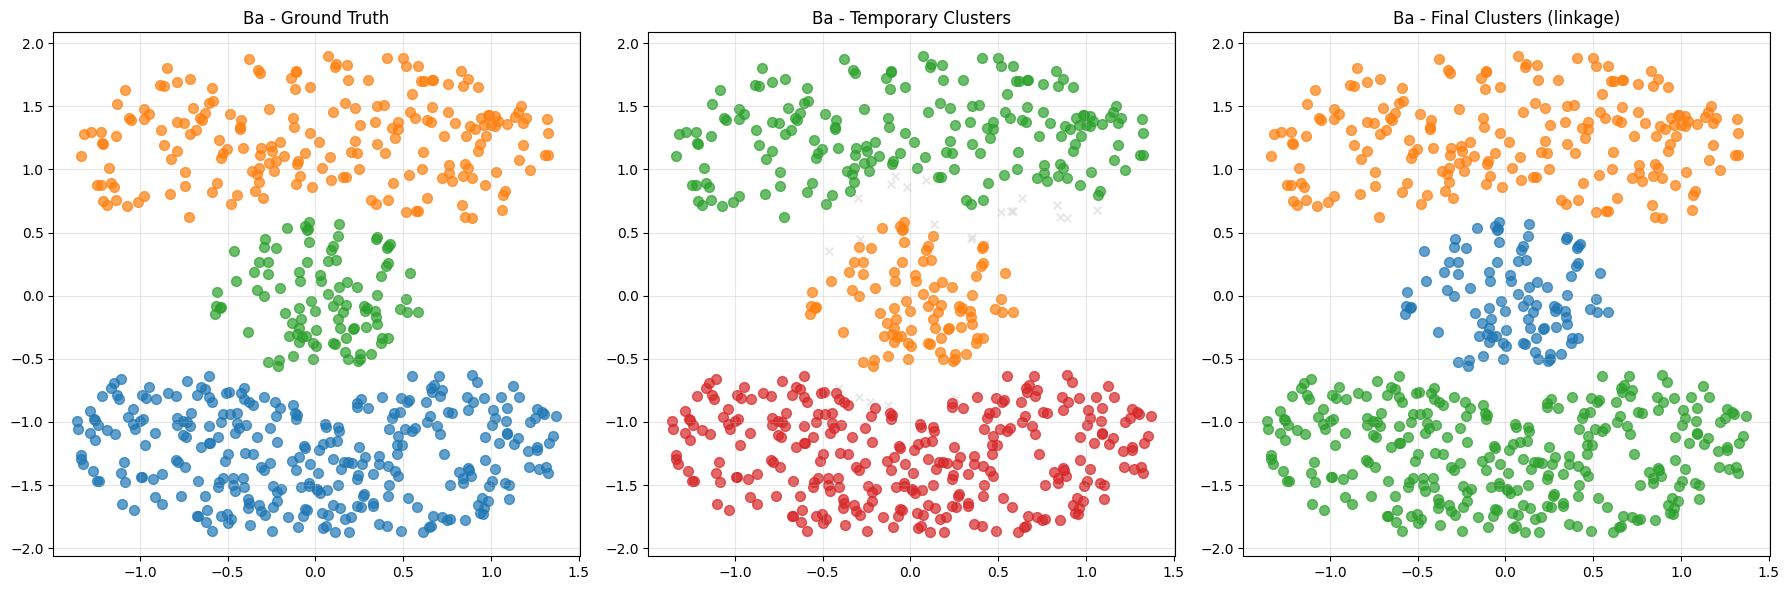

In [8]:
# 3. Ba Dataset
ba_data, ba_labels = load_mat_dataset('data/ba.mat', 'Ba')

result_ba = ADLCC_wrapper(
        data=ba_data,
        labels=ba_labels
    )
    
plot_clustering_results(ba_data,ba_labels,'Ba',result_ba)


In [ ]:

#If don't want to re-run everything, but want to test other classification methods can run codes like below.

# from auto_dlcc_functions import DAobs
# dm0 = result['dm_matrix']['dm']
# temp_clus_centroid = result['AUTO_DLCC_output']['centroid_res']['temp_clus']
# temp_clus_linkage = result['AUTO_DLCC_output']['linkage_res']['temp_clus']


# print("\nKNN method with centroid temp_clus:")
# knn_result_centroid = DAobs(
#     data=data,
#     temp_clus=temp_clus_centroid,
#     method='knn',
#     K_knn=7,
#     dm0=dm0
# )